In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import sys
sys.setrecursionlimit(1000000000)
import time

RECURSION_SET = set()

# ! ref: https://en.wikipedia.org/wiki/Octant_(solid_geometry)
OCTANTS = [
    (1,1,+1), (-1,1,+1), (-1,-1,+1), (1,-1,+1),
    (1,1,-1), (-1,1,-1), (-1,-1,-1), (1,-1,-1)
]

In [3]:
def get_range(radius, resolution):
    resolution = round(resolution, 3)
    re = [0]
    num = int(radius / resolution)
    # print("num => %s" %str(num))
    for i in range(num):
        re.append(round((i+1) * resolution, 3))
        # re.append(-(i+1) * resolution)
    return re

def sum_sqaure(a, b, c):
    re = (a * a) + (b * b) + (c * c)
    return re

def loop_sphere(radius, resolution, debug = False):
    time_start = time.time()
    re = []

    if radius <= 0:
        return re

    if resolution > radius:
        resolution = radius

    set_range = get_range(radius, resolution)
    # print("set_range => %s" %str(set_range))

    # limit_sq_max = radius + resolution* resolution
    # limit_sq_min = radius - resolution* resolution
    limit_sq_max = radius + resolution
    limit_sq_min = radius - resolution

    len_range = len(set_range)

    tot_points = set()
    for (i_z, z) in enumerate(set_range):
        i_x = len_range - 1
        while i_x >= i_z:
            i_y = 0
            while i_x >= i_y:
                s = sum_sqaure(set_range[i_x], set_range[i_y], set_range[i_z])
                if s >= limit_sq_min and s <= limit_sq_max:
                    if not debug:
                        for (s_x, s_y, s_z) in OCTANTS:
                            p1 = (s_x * set_range[i_x], s_y * set_range[i_y], s_z * set_range[i_z], 'A')
                            p2 = (s_x * set_range[i_y], s_y * set_range[i_x], s_z * set_range[i_z], 'A')
                            p3 = (s_x * set_range[i_z], s_y * set_range[i_y], s_z * set_range[i_x], 'A')
                            for p in [p1, p2, p3]:
                                tot_points.add(p)
                    else:
                        s_x = 1
                        s_y = 1
                        s_z = 1
                        p1 = (s_x * set_range[i_x], s_y * set_range[i_y], s_z * set_range[i_z], 'A')
                        p2 = (s_x * set_range[i_y], s_y * set_range[i_x], s_z * set_range[i_z], 'A')
                        p3 = (s_x * set_range[i_z], s_y * set_range[i_y], s_z * set_range[i_x], 'A')
                        for p in [p1, p2, p3]:
                            tot_points.add(p)
                i_y += 1
            i_x -= 1
    print(len(tot_points))     
    time_end = time.time()
    time_duration = time_end - time_start
    print("Duration (s) [function: loop_sphere]: %5.3f" %time_duration)
    
    return (tot_points)

def recursion_sphere(radius, resolution, debug = False):
    time_start = time.time()
    limit_sq_max = radius + resolution
    limit_sq_min = radius - resolution
    p0 = [radius, 0, 0]
    recursive_sphere(p0, radius, resolution, limit_sq_min, limit_sq_max)
    tot_points = set()
    if not debug:
        for (s_x, s_y, s_z) in OCTANTS:
            for p in RECURSION_SET:
                tot_points.add((s_x * p[0], s_y * p[1], s_z * p[2]))
    else:
        tot_points = RECURSION_SET
    print(len(tot_points)) 
    time_end = time.time()
    time_duration = time_end - time_start
    print("Duration (s) [function: recursion_sphere]: %5.3f" %time_duration)
    return (tot_points)

def recursive_sphere(p, r, resolution, limit_min, limit_max):
    if p[0] < 0 or p[1] < 0 or p[2] < 0 or p[0] > r or p[1] > r or p[2] > r:
        return

    s = sum_sqaure(p[0], p[1], p[2])    
    if s >= limit_min and s <= limit_max:
        RECURSION_SET.add(tuple(p))

    for i in range(3):
        p1 = list(p)
        p1[i] = round(p1[i] + resolution, 3)
        if s <= limit_max and tuple(p1) not in RECURSION_SET:
            recursive_sphere(p1, r, resolution, limit_min, limit_max)
        p2 = list(p)
        p2[i] = round(p2[i] - resolution, 3)
        if s >= limit_min and tuple(p2) not in RECURSION_SET:
            recursive_sphere(p2, r, resolution, limit_min, limit_max)
    
    return

def write_to_pdb(tot_points, fname = "sphere_test_out.pdb"):
    with open(fname, 'w') as fo:
        fo.write('REMARK this is a sphere\n')
        for i, v in enumerate(tot_points):
            if len(v) < 4:
                v3 = 'A'
            else:
                v3 = v[3]
            x = v[0]
            y = v[1]
            z = v[2]
  
            # ! ref: https://www.cgl.ucsf.edu/chimera/docs/UsersGuide/tutorials/pdbintro.html
            # ***  "00000 111111111222X2222233    3    4    5555566666666667"
            # ***  "12345-123456789012X3-78901----9----6----5678901234567890"
            line = "ATOM %s C    DUM %s%s    %8.3f%8.3f%8.3f  1.00  0.00  \n" % (f"{str(i+1) : >6}", v3, f"{str((i+1)%10000) : >4}",x,y,z)
            fo.write(line)
        fo.write('TER\n')

def benchmark_test():
    print("====Benchmark====")
    # Time(s): 0.087
    # Points: 125834
    tot_points = loop_sphere(1, 0.01)
    write_to_pdb(tot_points, fname = "benchmark_loop.pdb")

    # ! Note: set the stack for the environment
    # ! cmd: ulimit -s unlimited
    # Time(s): 2.988
    # Points: 125858
    tot_points= recursion_sphere(1, 0.01)
    write_to_pdb(tot_points, fname = "benchmark_recursion.pdb")
    print("====Benchmark Finished====\n")

def debug_test():
    print("====Debug====")
    tot_points = loop_sphere(1, 0.01, True)
    write_to_pdb(tot_points, fname = "debug_loop.pdb")

    tot_points= recursion_sphere(1, 0.01, True)
    write_to_pdb(tot_points, fname = "debug_recursion.pdb")
    print("====Debug Finished====\n")

125834
Duration (s) [function: loop_sphere]: 0.095


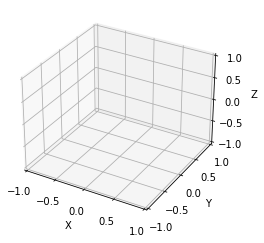

In [4]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

t = loop_sphere(1, 0.01)
xs,ys,zs = [],[],[]
for l in t:
    xs.append(l[0])
    ys.append(l[1])
    zs.append(l[2])
# t = recursion_sphere(1, 0.01)
# xs,ys,zs = [],[],[]
# for l in t:
#     xs.append(l[0])
#     ys.append(l[1])
#     zs.append(l[2])

# ax.scatter(xs, ys, zs, marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

plt.show()